# Linear Regression for Stock Prediction

#### 4 Components of time series
1. Trend - upwards or downwards movement over time
2. Noise - extraneous data that distracts from the underlying pattern
3. Cyclicity - underlying pattern that repeats over some time period
4. Seasonality - time period dependent pattern (ie. more heat strokes in the summer, more web search during the school year)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/ford_close.csv', header = None, names=['ClosingPrice'])

#### A plot of the data, pre-normalization

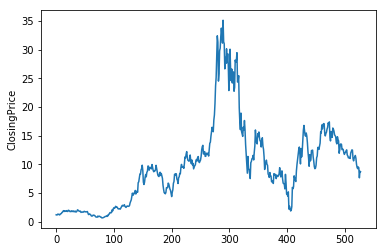

In [3]:
sns.lineplot(x=df.index,y=df['ClosingPrice']) #a look at the values we're attempting to predict

#### A plot of the data after standard normalizing

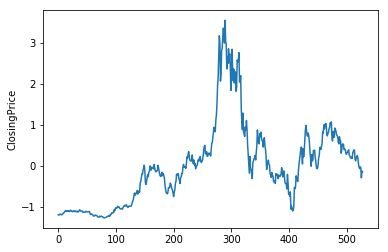

In [4]:
#standard normalizeing the data
scaler = StandardScaler()
df['ClosingPrice'] = scaler.fit_transform(df[['ClosingPrice']])
sns.lineplot(x=df.index,y=df['ClosingPrice']) #a look at the values we're attempting to predict

In [5]:
#rolling window of 5 data points
size=5
windows = [df[i:i+size] for i in range(0,df.shape[0],1)]

In [6]:
ln = LinearRegression()
predictions = []
for i in windows:
    #given a window of points, generate xtrain and ytrain
    ytrain = i.ix[:,0].tolist()
    xtrain = np.asarray(list(i.index)).reshape(-1,1)
    
    #generate xpred by incrementing last value of xtrain
    val = 1+xtrain[-1][0] 
    xpred = np.asarray(val).reshape(-1,1) 
    
    #fit and predict
    ln.fit(xtrain,ytrain) 
    predictions.append(ln.predict(xpred))

#### A plot of the predicted vs actual stock data

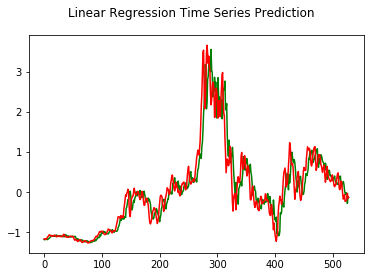

In [7]:
plt.plot(df.index,df['ClosingPrice'],c = 'green') #green line --> actual value
plt.plot(df.index,predictions, c = 'red') #red line --> prediction
plt.suptitle('Linear Regression Time Series Prediction')
plt.show()

In [8]:
r2 = r2_score(df['ClosingPrice'],predictions)
maxerror = max_error(df['ClosingPrice'],predictions)
meanabserror = mean_absolute_error(df['ClosingPrice'],predictions)
meansqrerror = mean_squared_error(df['ClosingPrice'],predictions)

In [9]:
print('r2 score:',r2)
print('max error:',maxerror)
print('mean absolute error:',meanabserror)
print('mean square error:',meansqrerror)

r2 score: 0.8537600957110518
max error: 1.9532079697660492
mean absolute error: 0.24714199500697231
mean square error: 0.1462399042889482


# LSTM for Stock Prediction

In [10]:
training_set = df.as_matrix()

In [11]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 5

In [12]:
data = training_data
x = []
y = []

for i in range(len(data)-seq_length-1):
    _x = data[i:(i+seq_length)]
    _y = data[i+seq_length]
    x.append(_x)
    y.append(_y)
x = np.array(x)
y = np.array(y)

In [13]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        #initialize params
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length #variable sequence length is 5
        
        #instantiate lstm
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        #linear layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [15]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 #1 expected input feature (stock price)
hidden_size = 2 #1 feature in the hidden state
num_layers = 1 #1 recurrent layer
num_classes = 1 #1 pred class

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #ADAM optimizer

In [16]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.25000
Epoch: 100, loss: 0.00205
Epoch: 200, loss: 0.00156
Epoch: 300, loss: 0.00139
Epoch: 400, loss: 0.00134
Epoch: 500, loss: 0.00131
Epoch: 600, loss: 0.00127
Epoch: 700, loss: 0.00124
Epoch: 800, loss: 0.00121
Epoch: 900, loss: 0.00118
Epoch: 1000, loss: 0.00116
Epoch: 1100, loss: 0.00115
Epoch: 1200, loss: 0.00115
Epoch: 1300, loss: 0.00114
Epoch: 1400, loss: 0.00114
Epoch: 1500, loss: 0.00114
Epoch: 1600, loss: 0.00114
Epoch: 1700, loss: 0.00114
Epoch: 1800, loss: 0.00114
Epoch: 1900, loss: 0.00114


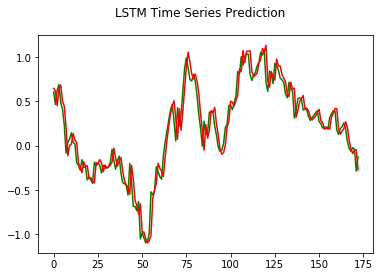

In [22]:
lstm.eval()
train_predict = lstm(testX)

#inverse the scaler transform and plot
data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(dataY_plot, color='green')
plt.plot(data_predict, color = 'red')
plt.suptitle('LSTM Time Series Prediction')
plt.show()

In [23]:
r2 = r2_score(dataY_plot,data_predict)
maxerror = max_error(dataY_plot,data_predict)
meanabserror = mean_absolute_error(dataY_plot,data_predict)
meansqrerror = mean_squared_error(dataY_plot,data_predict)

In [24]:
print('r2 score:',r2)
print('max error:',maxerror)
print('mean absolute error:',meanabserror)
print('mean square error:',meansqrerror)

r2 score: 0.9179306376081542
max error: 0.48983043
mean absolute error: 0.10751963
mean square error: 0.020069921
